# DenseNet-161 version 1 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# The specific torch version for this code
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install typeguard

In [0]:
# Import libraries
from fastai import *
from fastai.vision import *
import random
random.seed(23)

In [ ]:
# unzip data
!unzip 'data.zip'

In [0]:
# Load data
path_img = Path('data')

# set batch size
bs = 32

# Normalize data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)



ImageDataBunch;

Train: LabelList (1180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data;

Valid: LabelList (398 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data;

Test: None

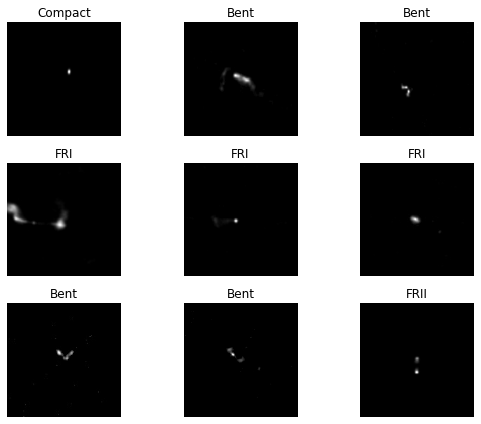

In [0]:
data.show_batch(rows=3, figsize=(8,6))

In [0]:
# Define model and metrics
learn = cnn_learner(data, models.densenet161, metrics=accuracy)

# Freeze the earlier layers and keep only the last layer trainable
learn.freeze()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 89.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-06
Min loss divided by 10: 6.76E-03


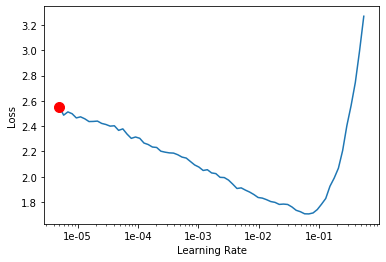

In [0]:
# Use lr_find to get the optimal learning rate
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.580846,1.089022,0.580402,01:02


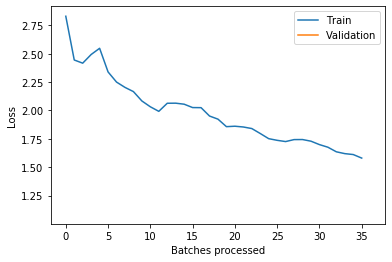

In [0]:
# Train the model using the lr from the plot for 1 epoch and check
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-2))

learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 6.92E-05


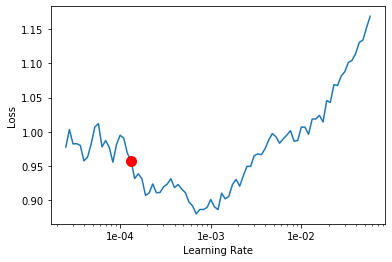

In [0]:
# Unfreeze all the layers and train the model from scratch
learn.unfreeze()

# Find the learning rate for the fully trainable model
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.107676,2.735700,0.545226,01:10
1,0.881977,0.800489,0.798995,01:09
2,0.683527,0.397831,0.866834,01:10


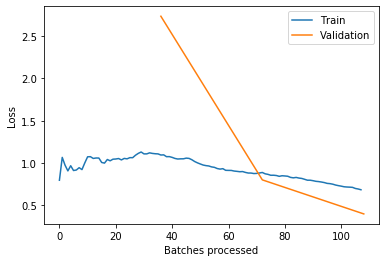

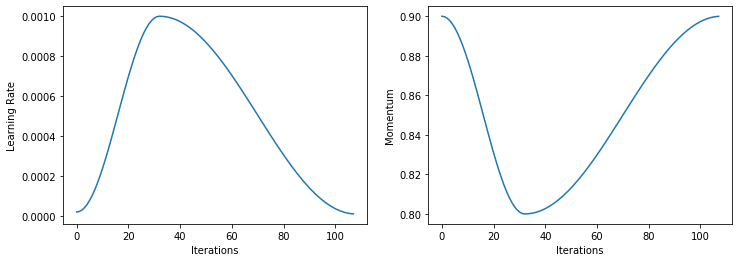

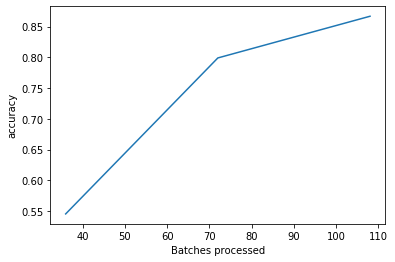

In [0]:
# Check with the obtained lr for few epochs
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), wd=1e-3, moms=(0.9, 0.8))
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.605623,1.070851,0.698492,01:10
1,0.609158,0.765436,0.751256,01:09
2,0.546718,0.672232,0.798995,01:09
3,0.510832,0.464455,0.826633,01:09
4,0.413079,0.388173,0.869347,01:09
5,0.360194,0.331441,0.879397,01:09
6,0.304720,0.287675,0.904523,01:09
7,0.237593,0.256043,0.919598,01:09
8,0.193312,0.246911,0.919598,01:09
9,0.171243,0.253282,0.909548,01:10


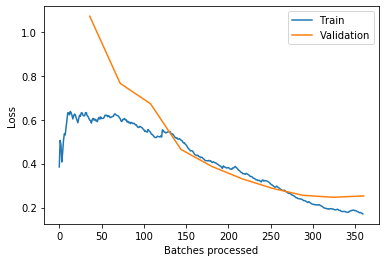

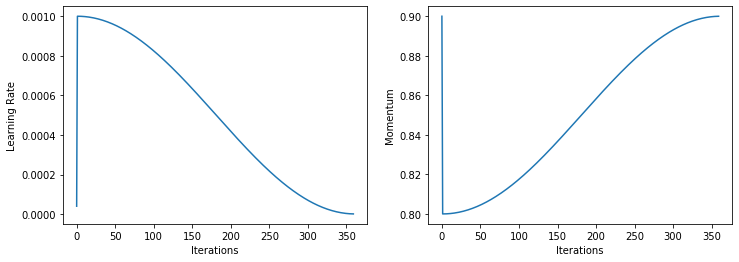

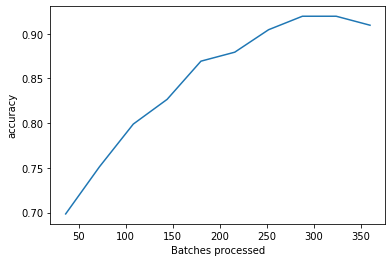

In [0]:
# Train the model
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-4, 1e-3), wd=1e-3, moms=(0.9, 0.8))
learn.recorder.plot_losses()

learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
# Save the model (saves in models directory)
learn.save('RG_model')

In [ ]:
# OPTIONAL: export the model as .pkl file
learn.export('RG_model.pkl')

In [0]:
# Load the model for validation check and create interpreter
learn.load('RG_model')
interp = ClassificationInterpretation.from_learner(learn)

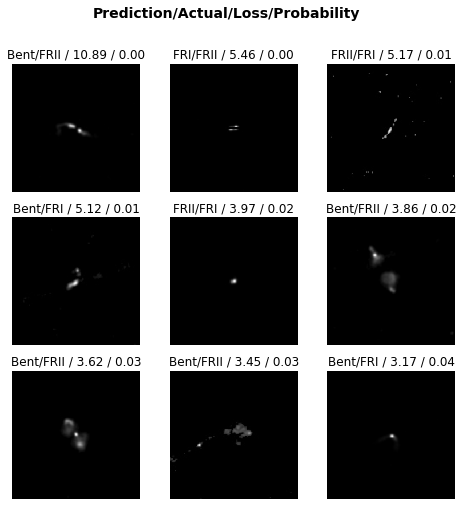

In [0]:
# Top losses from the model performance
interp.plot_top_losses(9, figsize=(8,8))

In [0]:
# OPTIONAL: Get the paths to top loss samples

losses, indexes = interp.top_losses(10)
top_loss_paths = data.valid_ds.x.items[indexes]
print(top_loss_paths)

[PosixPath('data/valid/FRII/J151108.76+180153.2.jpeg') PosixPath('data/valid/FRII/J144808.61+163439.5.jpg')
 PosixPath('data/valid/FRI/J140310.68+393949.8.jpeg') PosixPath('data/valid/FRI/J143521.30-024051.7.jpg')
 PosixPath('data/valid/FRI/J141104.33-030043.3.jpeg') PosixPath('data/valid/FRII/J144919.01+210548.0.jpg')
 PosixPath('data/valid/FRII/J145942.07+290334.1.jpg') PosixPath('data/valid/FRII/J153004.69+290009.3.jpg')
 PosixPath('data/valid/FRI/J140313.27+061008.2.jpeg') PosixPath('data/valid/FRI/J143825.92-010001.5.jpg')]


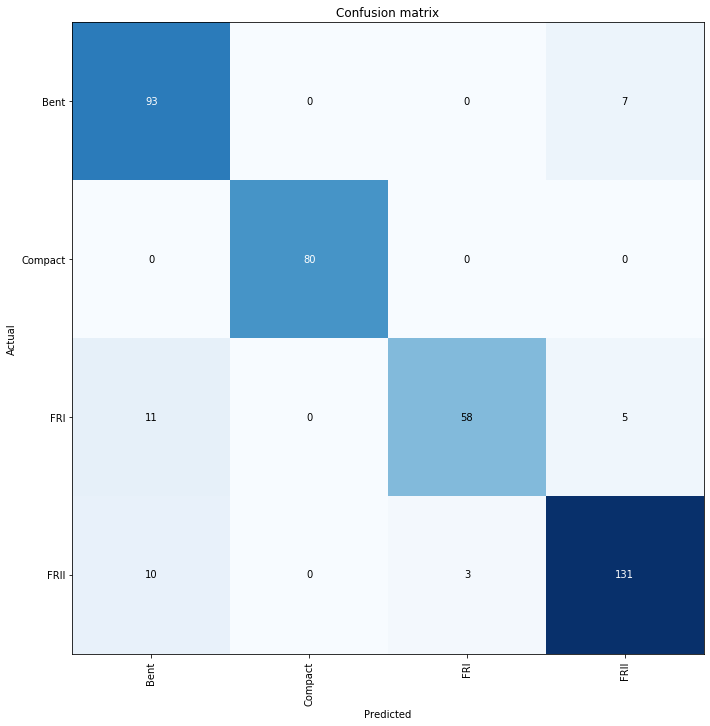

In [0]:
# Get the confusion matrix for validation data
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
# TP: True Positive

import glob

image_list = glob.glob('data/test/*/*')

Bent, Pred_Bent = 0
Compact, Pred_Compact = 0
FRI, Pred_FRI=0
FRII, Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FRI':
        FRI += 1
        if pred_class == 'FRI':
            Pred_FRI += 1
    elif rg_class == 'FRII':
        FRII += 1
        if pred_class == 'FRII':
            Pred_FRII += 1
            
    
print('Bent TP: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact TP: ' + str(Pred_Compact) + '/' + str(Compact))
print('FRI TP: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FRII TP: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent TP: 98/103
Compact TP: 95/100
FRI TP: 91/100
FRII TP: 89/101


## Another way to get the results on Test data

In [0]:
# The data folder contains the 'test' directory
# Provide the 'test' directory as input to 'valid' parameter in defining ImageDataBunch 

path_img = Path('data')
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: data;

Test: None

In [0]:
# Define the architecture
learn = cnn_learner(data, models.densenet161, metrics=[accuracy])

In [0]:
# Load the trained and saved model
learn = learn.load('models/RG_model')

In [0]:
# Get the interpreter
interp = ClassificationInterpretation.from_learner(learn)

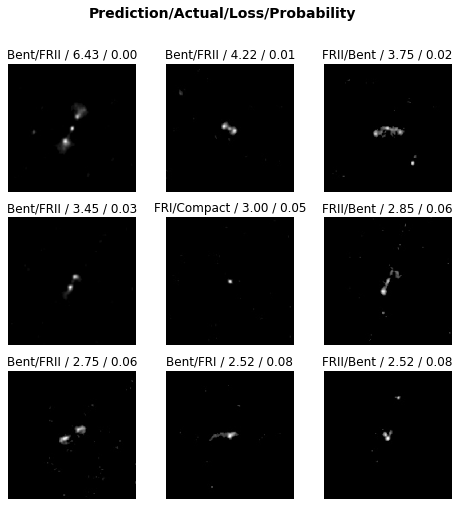

In [0]:
# Plot top losses from the test data
interp.plot_top_losses(9, figsize=(8,8))

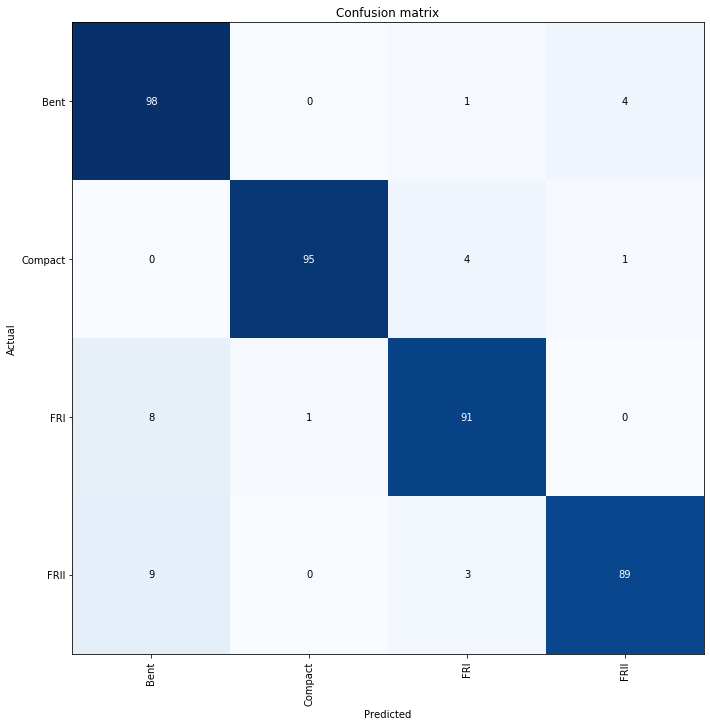

In [0]:
interp.plot_confusion_matrix(figsize=(10,10))